In [2]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

#from preprocessing import preprocess
plt.rcParams["figure.dpi"] = 150

In [3]:
# from collections import Counter
# import requests

# with requests.get(
#     "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
#     for chunk in r.iter_content():
#         f.write(chunk)

# with requests.get(
#     "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
#     for chunk in r.iter_content():
#         f.write(chunk)

In [4]:
df_features = pd.read_csv("features.csv")
df_target = pd.read_csv("target.csv")
df = df_features.merge(df_target, left_on='id', right_on='id')


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def basic_preprocessing(df: pd.DataFrame, test_size=0.1):
    df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')    
    df['dia'] = pd.to_datetime(df['dia'])
    df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente']) 
    df = df.dropna(subset=['llovieron_hamburguesas_hoy'])
    df = df.drop(columns = ['id'])
    df['mes'] = df['dia'].dt.month
    df = df.drop(columns = ['dia']) 
    df = df[df.isnull().mean(1) < 0.4]
    
    label_encoder = preprocessing.LabelEncoder()
    
    label_encoder.fit(df['llovieron_hamburguesas_hoy'])
    df['llovieron_hamburguesas_hoy'] = label_encoder.transform(df['llovieron_hamburguesas_hoy'])

    label_encoder.fit(df['llovieron_hamburguesas_al_dia_siguiente'])
    df['llovieron_hamburguesas_al_dia_siguiente'] = label_encoder.transform(df['llovieron_hamburguesas_al_dia_siguiente'])
    
    
    X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
    y = df['llovieron_hamburguesas_al_dia_siguiente']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=test_size, stratify=y.astype(str))
    
    numerical_features = ['horas_de_sol', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde',
                       'rafaga_viento_max_velocidad', 'humedad_tarde', 'temperatura_tarde', 'mm_lluvia_dia',
                       'velocidad_viendo_tarde', 'humedad_temprano', 'velocidad_viendo_temprano', 'temperatura_temprano',
                       'temp_min', 'temp_max', 'mm_evaporados_agua']
    
    for feature in numerical_features:
        if feature == 'mm_lluvia_dia' or feature == 'mm_evaporados_agua':
            X_train[feature] = X_train[feature].fillna(X_train[feature].median())
            X_test[feature] = X_test[feature].fillna(X_test[feature].median())
        else:
            X_train[feature] = X_train[feature].fillna(X_train[feature].mean())
            X_test[feature] = X_test[feature].fillna(X_test[feature].mean())
            
    
    return X_train, X_test, y_train, y_test

In [11]:
def preprocessing1(df: pd.DataFrame):
    X_train, X_test, y_train, y_test = basic_preprocessing(df)
    
    X_train = X_train.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'mes', 'llovieron_hamburguesas_hoy', 'barrio']) 
    X_test = X_test.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'mes', 'llovieron_hamburguesas_hoy', 'barrio']) 
    
    return X_train, X_test, y_train, y_test

In [12]:
def preprocessing2(df: pd.DataFrame):
    X_train, X_test, y_train, y_test = basic_preprocessing(df)

    X_train = X_train.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'mes', 'barrio',
                           'horas_de_sol', 'nubosidad_tarde', 'nubosidad_temprano', 'temperatura_temprano', 'presion_atmosferica_temprano',
                           'velocidad_viendo_temprano', 'temperatura_temprano', 'temp_min', 'temp_max']) 
    
    X_test = X_test.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'mes', 'barrio',
                           'horas_de_sol', 'nubosidad_tarde', 'nubosidad_temprano', 'temperatura_temprano', 'presion_atmosferica_temprano',
                           'velocidad_viendo_temprano', 'temperatura_temprano', 'temp_min', 'temp_max'])
    
    return X_train, X_test, y_train, y_test

In [13]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()



In [18]:
X_train1, X_test1, y_train1, y_test1 = preprocessing1(df)

params = {
    'var_smoothing': np.arange(0.0001, 1, 0.0001)
}

gnb1 = GaussianNB()

rgscv1 = RandomizedSearchCV(
    gnb1, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train1, y_train1)

print(f"Best score: {rgscv1.best_score_}")
print(f"Best params {rgscv1.best_params_}")

Best score: 0.8356564095387569
Best params {'var_smoothing': 0.020900000000000002}


In [19]:
X_train2, X_test2, y_train2, y_test2 = preprocessing2(df)

params = {
    'var_smoothing': np.arange(0.0001, 1, 0.0001)
}

gnb2 = GaussianNB()

rgscv2 = RandomizedSearchCV(
    gnb2, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train2, y_train2)

print(f"Best score: {rgscv2.best_score_}")
print(f"Best params {rgscv2.best_params_}")

Best score: 0.8258930704113021
Best params {'var_smoothing': 0.1387}


In [23]:
X_train, X_test, y_train, y_test = preprocessing1(df)

gnb = GaussianNB(var_smoothing=0.0209)
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
y_pred_proba = gnb.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Auc Roc: {roc_auc_score(y_test, y_pred_proba)}")

Accuracy: 0.8232595790609822
Precision: 0.6158594491927826
Recall: 0.5287403179779862
Auc Roc: 0.8361271300330813


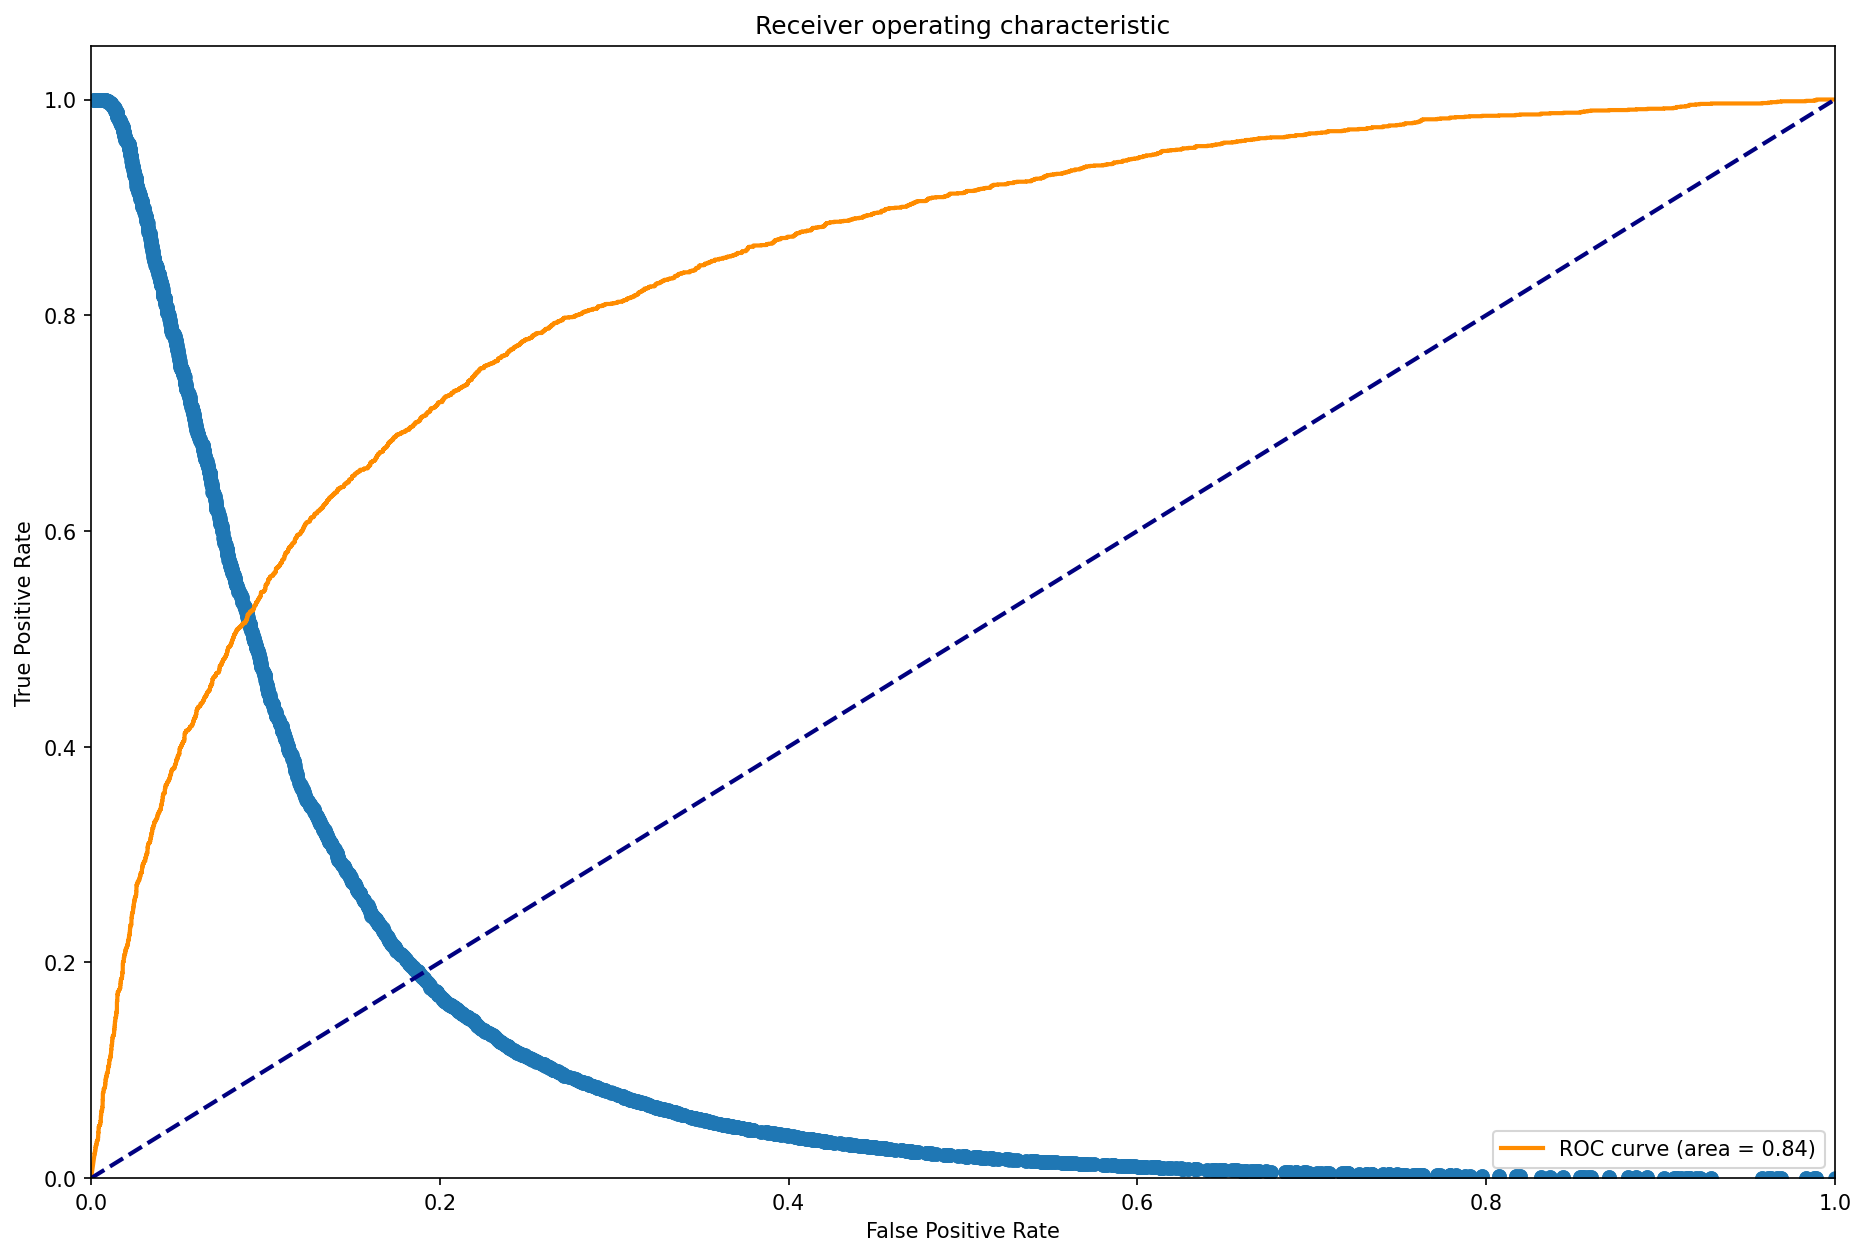

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plot_roc(fpr, tpr, thresholds)